In [1]:
import os
import pandas as pd
import torch
from transformers import XLMRobertaTokenizer, XLMRobertaForSequenceClassification, Trainer, TrainingArguments, DataCollatorWithPadding
from transformers import TrainerCallback
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt


In [2]:
# Step 1: Load Dataset
base_path = '/kaggle/input/dl-project-dataset/Split Preprocessed Data'

def load_split_data(base_path, split):
    split_path = os.path.join(base_path, split)
    data = []
    labels = []
    eras = []  # To store human-readable eras (e.g., "1900-1950")
    
    # Define a mapping of folder names to eras
    era_mapping = {
        "1850": "1800-1850",
        "1900": "1850-1900",
        "1950": "1900-1950",
        "2000": "1950-2000",
        "2024": "2000-2024",
    }

    for era_folder in os.listdir(split_path):
        era_path = os.path.join(split_path, era_folder)
        if era_folder in era_mapping:
            era_label = era_mapping[era_folder]  # Map folder name to era
        else:
            raise ValueError(f"Unknown folder name: {era_folder}")
        
        for file in os.listdir(era_path):
            file_path = os.path.join(era_path, file)
            with open(file_path, 'r', encoding='utf-8') as f:
                text = f.read()
                data.append(text)
                labels.append(era_label)  # Use the human-readable era as the label
                eras.append(era_folder)  # Optionally store the folder name for debugging

    return pd.DataFrame({'text': data, 'label': labels, 'era': eras})  # Include the era column for debugging if needed

# Load train, validation, and test data
train_data = load_split_data(base_path, 'train')
val_data = load_split_data(base_path, 'val')
test_data = load_split_data(base_path, 'test')

print(f"Train samples: {len(train_data)}, Validation samples: {len(val_data)}, Test samples: {len(test_data)}")
print(train_data['label'].value_counts())  # Print distribution of eras for debugging


Train samples: 5119, Validation samples: 639, Test samples: 644
label
2000-2024    2024
1950-2000     976
1900-1950     923
1800-1850     681
1850-1900     515
Name: count, dtype: int64


In [3]:
# Step 2: Tokenize Data
tokenizer = XLMRobertaTokenizer.from_pretrained('xlm-roberta-base')

def tokenize_data(data):
    return tokenizer(list(data['text']), truncation=True, padding=True, max_length=512)

train_encodings = tokenize_data(train_data)
val_encodings = tokenize_data(val_data)
test_encodings = tokenize_data(test_data)


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.10M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/615 [00:00<?, ?B/s]

/opt/conda/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [4]:
# Step 3: Map Eras to Numeric Labels
era_to_label = {era: idx for idx, era in enumerate(train_data['label'].unique())}  # Map eras to numeric labels
label_to_era = {idx: era for era, idx in era_to_label.items()}  # Reverse mapping for inference

train_data['numeric_label'] = train_data['label'].map(era_to_label)
val_data['numeric_label'] = val_data['label'].map(era_to_label)
test_data['numeric_label'] = test_data['label'].map(era_to_label)


In [5]:
# Step 4: Create Dataset Class
class EraDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return {
            'input_ids': self.encodings['input_ids'][idx],
            'attention_mask': self.encodings['attention_mask'][idx],
            'labels': torch.tensor(self.labels[idx], dtype=torch.long)
        }

train_dataset = EraDataset(train_encodings, train_data['numeric_label'].values)
val_dataset = EraDataset(val_encodings, val_data['numeric_label'].values)
test_dataset = EraDataset(test_encodings, test_data['numeric_label'].values)


In [6]:
# Step 5: Load Model
num_labels = len(era_to_label)  # Number of unique eras
model = XLMRobertaForSequenceClassification.from_pretrained('xlm-roberta-base', num_labels=num_labels)


model.safetensors:   0%|          | 0.00/1.12G [00:00<?, ?B/s]

Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [7]:
# Step 6: Define Training Arguments
training_args = TrainingArguments(
    output_dir='./results',
    eval_strategy="epoch",  # Validation loss per epoch
    logging_strategy="steps",  # Log training loss per step
    logging_steps=10,         # Log every 10 steps
    learning_rate=2e-5,
    num_train_epochs=3,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    weight_decay=0.01,
    save_total_limit=2,
    report_to="none"  # Disable wandb and other integrations
)


In [8]:
# Step 7: Data Collator
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)


In [9]:
# Step 8: Define Trainer with Loss Logging Callback
class LossLoggerCallback(TrainerCallback):
    """
    Custom callback to log and store loss values during training.
    """
    def __init__(self):
        self.epochs = []
        self.training_losses = []
        self.validation_losses = []

    def on_log(self, args, state, control, logs=None, **kwargs):
        if logs:
            print("Logs at this step:", logs)  # Debugging: Print logs
        if 'loss' in logs:  # Training loss
            self.training_losses.append(logs['loss'])
        if 'eval_loss' in logs:  # Validation loss
            self.validation_losses.append(logs['eval_loss'])
        if 'epoch' in logs and logs['epoch'] not in self.epochs:  # Avoid duplicate epochs
            self.epochs.append(logs['epoch'])

loss_logger = LossLoggerCallback()

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    data_collator=data_collator,
    callbacks=[loss_logger]  # Add custom callback to Trainer
)


In [10]:
# Step 9: Train the Model
trainer.train()

# Save the model and tokenizer
model.save_pretrained('./era_model')
tokenizer.save_pretrained('./era_model')

/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


Logs at this step: {'loss': 1.5489, 'grad_norm': 4.908350944519043, 'learning_rate': 1.9583333333333333e-05, 'epoch': 0.0625}
Logs at this step: {'loss': 1.5374, 'grad_norm': 6.937679290771484, 'learning_rate': 1.916666666666667e-05, 'epoch': 0.125}
Logs at this step: {'loss': 1.4325, 'grad_norm': 3.4263501167297363, 'learning_rate': 1.8750000000000002e-05, 'epoch': 0.1875}
Logs at this step: {'loss': 1.4891, 'grad_norm': 3.0816104412078857, 'learning_rate': 1.8333333333333333e-05, 'epoch': 0.25}
Logs at this step: {'loss': 1.4205, 'grad_norm': 6.769618034362793, 'learning_rate': 1.7916666666666667e-05, 'epoch': 0.3125}
Logs at this step: {'loss': 1.3917, 'grad_norm': 9.203283309936523, 'learning_rate': 1.7500000000000002e-05, 'epoch': 0.375}
Logs at this step: {'loss': 1.443, 'grad_norm': 11.91036605834961, 'learning_rate': 1.7083333333333333e-05, 'epoch': 0.4375}
Logs at this step: {'loss': 1.3633, 'grad_norm': 4.128547191619873, 'learning_rate': 1.6666666666666667e-05, 'epoch': 0.5}

/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


Logs at this step: {'eval_loss': 0.37981441617012024, 'eval_runtime': 13.2261, 'eval_samples_per_second': 48.314, 'eval_steps_per_second': 1.512, 'epoch': 3.0}
Logs at this step: {'train_runtime': 1015.8133, 'train_samples_per_second': 15.118, 'train_steps_per_second': 0.473, 'total_flos': 4040705313819648.0, 'train_loss': 0.8914557332793872, 'epoch': 3.0}


('./era_model/tokenizer_config.json',
 './era_model/special_tokens_map.json',
 './era_model/sentencepiece.bpe.model',
 './era_model/added_tokens.json')

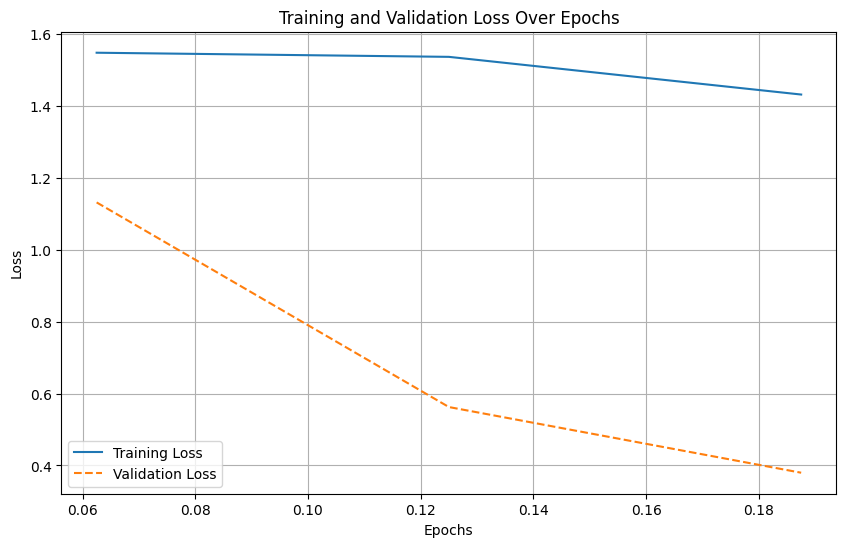

In [11]:
# Step 12: Plot Training and Validation Loss
def plot_loss(epochs, training_losses, validation_losses):
    min_length = min(len(epochs), len(training_losses), len(validation_losses))
    epochs = epochs[:min_length]
    training_losses = training_losses[:min_length]
    validation_losses = validation_losses[:min_length]

    plt.figure(figsize=(10, 6))
    plt.plot(epochs, training_losses, label="Training Loss")
    plt.plot(epochs, validation_losses, label="Validation Loss", linestyle="--")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Training and Validation Loss Over Epochs")
    plt.legend()
    plt.grid(True)
    plt.show()

plot_loss(loss_logger.epochs, loss_logger.training_losses, loss_logger.validation_losses)


In [12]:
# Step 10: Evaluate the Model
predictions = trainer.predict(test_dataset)
predicted_labels = torch.argmax(torch.tensor(predictions.predictions), axis=1)
print(classification_report(test_data['numeric_label'], predicted_labels, target_names=list(label_to_era.values())))


              precision    recall  f1-score   support

   2000-2024       0.94      0.98      0.96       254
   1800-1850       0.90      0.90      0.90        86
   1850-1900       0.81      0.88      0.84        65
   1900-1950       0.91      0.90      0.90       116
   1950-2000       0.92      0.80      0.86       123

    accuracy                           0.91       644
   macro avg       0.89      0.89      0.89       644
weighted avg       0.91      0.91      0.91       644



# Confusion Matrix 

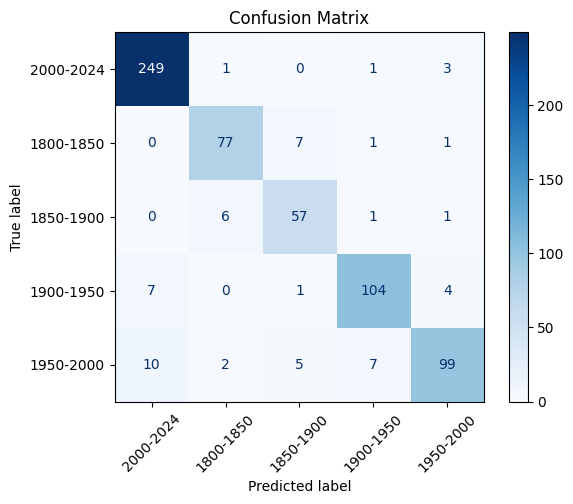

In [14]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Generate confusion matrix
y_true = test_data['numeric_label']
y_pred = predicted_labels  # Predicted labels from the model

cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=list(label_to_era.values()))

# Plot the confusion matrix
disp.plot(cmap='Blues', xticks_rotation=45)
plt.title("Confusion Matrix")
plt.show()
